# Convolve Shape

Divide the structure into smaller fragments and compare against our known fragments

In [1]:
import os
import pymol
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pymol
import rmsd
from pymol import cmd
import ampal
from scipy.cluster.hierarchy import fcluster

def calculate_RMSD_pymol(reference_pdb_path, fragment_pdb_path, normalize=True) -> float:
    pymol.pymol_argv = ["pymol", "-qc"]  # Quiet mode, without GUI
    pymol.finish_launching()
    
    cmd.delete("all")  # Clear any loaded objects
    cmd.load(reference_pdb_path, object="reference")
    cmd.load(fragment_pdb_path, object="fragment")

    # Perform the structural alignment using the align command
    alignment_result = cmd.align("reference and name CA", "fragment and name CA")
    rmsd = alignment_result[0]  # Extract RMSD from the result

    if normalize:
        # Calculate the number of aligned residues
        aligned_residues = alignment_result[1]
        # Normalizing RMSD by the square root of the number of aligned residues
        # This normalization aims to account for differences in alignment size but does not correspond to RMSD100
        normalized_rmsd = rmsd / (aligned_residues ** 0.5)
        return normalized_rmsd
    else:
        return rmsd

def calculate_RMSD_ampal(reference_pdb_path, fragment_pdb_path, normalize=True) -> float:
    # Load structures using AMPAL
    reference_structure = ampal.load_pdb(reference_pdb_path).backbone
    fragment_structure = ampal.load_pdb(fragment_pdb_path).backbone
    
    # Select C-alpha atoms from both structures
    reference_ca_atoms = reference_structure.get_atoms(ligands=False)
    fragment_ca_atoms = fragment_structure.get_atoms(ligands=False)

    # Extract coordinates
    reference_coords = np.array([atom._vector for atom in reference_ca_atoms if atom.res_label == "CA"])
    fragment_coords = np.array([atom._vector for atom in fragment_ca_atoms if atom.res_label == "CA"])

    # Align the structures using Kabsch algorithm
    fragment_coords_aligned = rmsd.kabsch_rotate(fragment_coords, reference_coords)
    
    # Calculate RMSD
    rmsd_value = rmsd.rmsd(reference_coords, fragment_coords_aligned)
    
    if normalize:
        # Normalize the RMSD by the square root of the number of aligned residues
        normalized_rmsd = rmsd_value / np.sqrt(len(reference_coords))
        return normalized_rmsd
    else:
        return rmsd_value

def load_pdb_paths(folder_path):
    pdb_paths = {}
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".pdb1"):
                fragment_number = os.path.basename(root)  # Assuming the folder name represents the fragment number
                pdb_paths[fragment_number] = os.path.join(root, file)
                break  # Stop searching after the first .pdb file is found in the folder
    return pdb_paths

def calculate_rmsd_matrix(fragment_to_path, rmsd_function):
    # Initialize an empty matrix for RMSD values
    fragment_names = list(fragment_to_path.keys())
    n = len(fragment_names)
    rmsd_matrix = np.zeros((n, n))
    
    # Calculate RMSD for each pair of fragments
    for i, name_i in enumerate(fragment_names):
        for j, name_j in enumerate(fragment_names[i+1:], start=i+1):
            rmsd = rmsd_function(fragment_to_path[name_i], fragment_to_path[name_j])
            rmsd_matrix[i, j] = rmsd
            rmsd_matrix[j, i] = rmsd  # Symmetric matrix
    
    return rmsd_matrix, fragment_names

def perform_hierarchical_clustering_and_form_clusters(rmsd_matrix, fragment_names):
    # Convert the RMSD matrix to a condensed form since linkage requires a condensed distance matrix
    condensed_rmsd = squareform(rmsd_matrix, checks=False)  # Assuming rmsd_matrix is symmetric and square

    # Perform hierarchical clustering using the 'complete' linkage method
    Z = linkage(condensed_rmsd, 'complete')

    # Form clusters based on a threshold RMSD of 0.5
    clusters = fcluster(Z, t=0.5, criterion='distance')
    # Mapping each fragment to its cluster
    fragment_cluster_mapping = {name: cluster for name, cluster in zip(fragment_names, clusters)}
    
    # Plot dendrogram
    plt.figure(figsize=(10, 8))
    dendrogram(Z, labels=fragment_names, orientation='right', leaf_font_size=10)
    plt.title('Hierarchical Clustering of Fragments Based on RMSD')
    plt.xlabel('RMSD')
    plt.ylabel('Fragments')
    
    # Draw a vertical line at RMSD = 0.5
    plt.axvline(x=0.5, color='r', linestyle='--', label='RMSD = 0.5')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fragment_cluster_mapping
# Assuming calculate_RMSD and load_pdb_paths functions are defined as in previous steps
folder_path = '../data/fragments/'
fragment_to_path = load_pdb_paths(folder_path)


 Matrix: Warning: no convergence (0.00000010<391.51177979 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<391.51177979 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<38.76883698 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<139.58085632 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<139.58085632 after 1000 iterations).


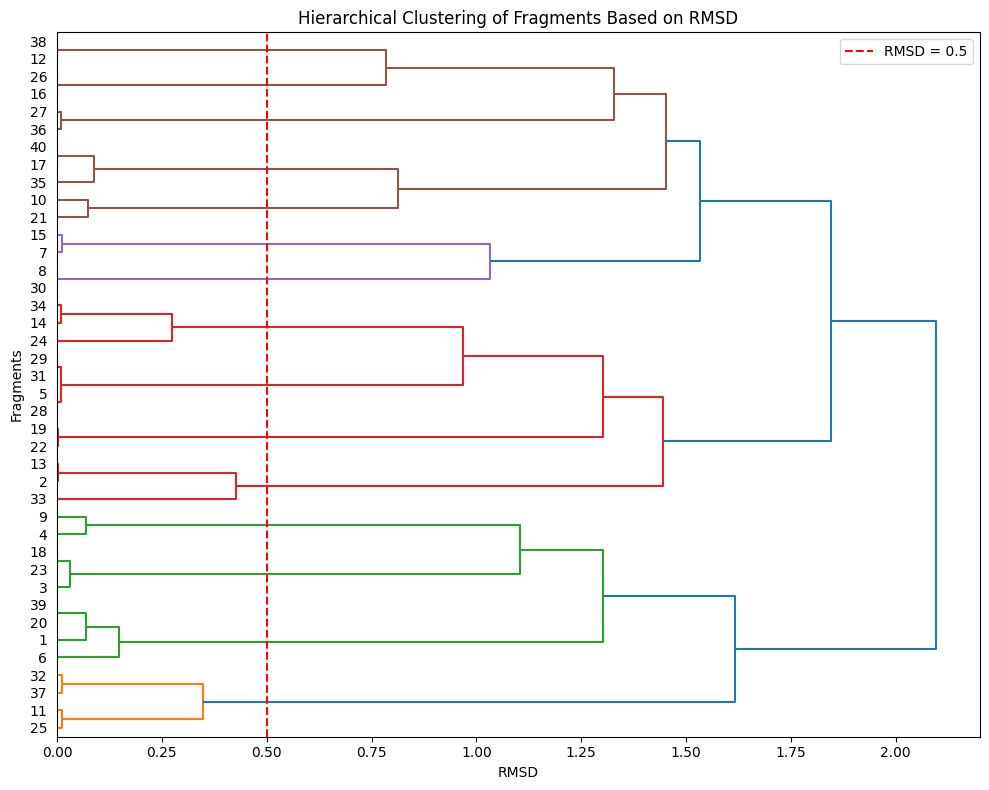

In [3]:
rmsd_matrix, fragment_names = calculate_rmsd_matrix(fragment_to_path, rmsd_function=calculate_RMSD_pymol)
clusters = perform_hierarchical_clustering_and_form_clusters(rmsd_matrix, fragment_names)

In [4]:
!pip install ampal

In [25]:
import pymol
from pymol import cmd, stored

def calculate_rmsd_pymol(reference_pdb, fragment_pdb, step_size=1):
    # Initialize PyMOL
    pymol.pymol_argv = ['pymol', '-qc']  # Quiet mode, no GUI
    pymol.finish_launching()

    # Load the structures
    cmd.reinitialize()  # Ensure a clean PyMOL session
    cmd.load(reference_pdb, "reference")
    cmd.load(fragment_pdb, "fragment")

    # Determine the size of the fragment (window size)
    cmd.select("fragment_ca", "fragment and name CA")
    window_size = cmd.count_atoms("fragment_ca")

    # Get the total number of amino acids in the reference
    n_reference_amino_acids = cmd.count_atoms("reference and name CA")

    # Prepare to store RMSD values
    rmsd_values = []

    # Iterate over the reference structure in windows of size determined by the fragment
    for start_resi in range(1, n_reference_amino_acids - window_size + 2, step_size):
        end_resi = start_resi + window_size - 1
        window_selection = f"reference and name CA and resi {start_resi}-{end_resi}"
        cmd.select("current_window", window_selection)

        # Temporary object for the current window
        cmd.create("temp_window", "current_window")

        # Align the temporary object to the fragment_ca selection and calculate RMSD
        rmsd = cmd.align("temp_window", "fragment_ca")[0]
        rmsd_values.append(rmsd)

        # Clean up temporary object
        cmd.delete("temp_window")

    # Clean up selections and objects
    cmd.delete("fragment_ca")
    cmd.delete("current_window")

    return rmsd_values


# Example usage
reference_pdb = "../data/pdbs/1A8P.pdb1"
fragment_pdb = fragment_to_path['1']
step_size = 1  # Define your step size here
rmsd_values_pymol = calculate_sliding_rmsd(reference_pdb, fragment_pdb, step_size)
rmsd_values_pymol

[3.9483234882354736,
 3.9483234882354736,
 3.9483234882354736,
 3.9483234882354736,
 3.9483234882354736,
 3.9483234882354736,
 3.9483234882354736,
 3.9483234882354736,
 3.9483234882354736,
 3.9483234882354736,
 3.344162940979004,
 2.5682313442230225,
 0.0030541778542101383,
 0.0030541778542101383,
 0.0,
 0.32300883531570435,
 0.012558524496853352,
 0.012558524496853352,
 2.586620569229126,
 2.586620569229126,
 2.586620569229126,
 0.6184231638908386,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 1.6028906106948853,
 0.9940479397773743,
 0.004308336414396763,
 3.199795722961426,
 3.199795722961426,
 3.199795722961426,
 3.199795722961426,
 3.199795722961426,
 3.199795722961426,
 3.199795722961426,
 3.19

In [44]:
import ampal
import numpy as np
import rmsd

import ampal
import numpy as np
import rmsd

def calculate_rmsd_ampal(reference_pdb_path, fragment_pdb_path, step_size=1, normalize=True):

    # Load structures using AMPAL
    reference_structure = ampal.load_pdb(reference_pdb_path)
    fragment_structure = ampal.load_pdb(fragment_pdb_path)
    if isinstance(reference_structure, ampal.AmpalContainer):
        reference_structure = reference_structure[0]  # Select the first chain if there are multiple
    if isinstance(reference_structure, ampal.Assembly):
        reference_structure = reference_structure[0]  # Select the first chain if there are multiple
    # Determine the size of the fragment (window size)
    fragment_monomers = list(fragment_structure.get_monomers(ligands=False))
    fragment_length = len(fragment_monomers)
    reference_monomers = list(reference_structure.get_monomers(ligands=False))


    # Prepare to store RMSD values, initialized with None or another placeholder
    rmsd_values = [None] * len(reference_monomers)  # Placeholder values

    # Iterate over the reference structure using actual residue IDs
    for i in range(0, len(reference_monomers) - fragment_length + 1, step_size):
        segment_monomers = reference_monomers[i:i + fragment_length]

        # Extract C-alpha coordinates from the segment and the fragment
        segment_ca_coords = np.array([atom._vector for residue in segment_monomers for atom in residue if atom.res_label == 'CA'])
        fragment_ca_coords = np.array([atom._vector for residue in fragment_monomers for atom in residue if atom.res_label == 'CA'])
        
        # Align the structures using the Kabsch algorithm and calculate RMSD
        current_rmsd = rmsd.e(segment_ca_coords, fragment_ca_coords)
        #current_rmsd = rmsd.rmsd(segment_ca_coords_aligned, fragment_ca_coords)

        rmsd_values[i] = current_rmsd  # Store the RMSD at the starting position of the segment

    assert len(rmsd_values) == len(reference_structure)
    return rmsd_values

# Example usage
step_size = 1  # Define your step size here
reference_pdb = "../data/pdbs/1A8P.pdb1"
rmsd_values_ampal = calculate_rmsd_ampal(reference_pdb, fragment_to_path['1'], step_size)
rmsd_values_ampal

[25.498357287874367,
 25.602067451584194,
 25.470975918772506,
 25.322776139417634,
 25.16887861298774,
 25.39399661758655,
 25.775074502902903,
 26.49777505226059,
 27.278525033955518,
 27.970520241678074,
 28.725671865599107,
 29.456920895414637,
 30.02972216458195,
 30.424651797604458,
 30.494340326911438,
 30.30041448885197,
 29.926368700072537,
 29.387033624800942,
 28.80042913758747,
 28.308934361520596,
 27.858107211016765,
 27.58553536548647,
 27.4031406260393,
 27.47796741043929,
 27.573363410887467,
 27.539379713103877,
 27.50563687758447,
 27.241575566486045,
 26.916197968879267,
 26.57866985020507,
 25.95333592566594,
 25.146787458771904,
 24.110142056995183,
 22.987028829780368,
 21.922836793381894,
 21.37036863154552,
 21.18082290800748,
 21.478425692516293,
 22.042645836143656,
 22.933096374123092,
 23.873042036479408,
 24.805853254392733,
 25.81434916103514,
 26.823355538343968,
 27.85698169446741,
 28.851426188544526,
 29.74333211662712,
 30.34982906770781,
 30.8089428

In [72]:
from Bio.PDB import PDBParser, Superimposer
import numpy as np
import ampal

from Bio.PDB import PDBParser, Superimposer
import numpy as np

from Bio.PDB import PDBParser
from Bio.PDB.cealign import CEAligner

import numpy as np
import tempfile

from Bio.PDB import PDBParser
import numpy as np


def get_residue_ids(protein_structure):
    """Returns a list of residue IDs from an AMPAL structure."""
    return [residue.id for residue in protein_structure.get_monomers()]

def calculate_rmsd_cealign(reference_pdb_path, fragment_pdb_path, window_size, step_size=1, normalize=True):
    parser = PDBParser()
    ce_aligner = CEAligner()

    # Load structures
    reference_structure = ampal.load_pdb(reference_pdb_path)
    if isinstance(reference_structure, ampal.AmpalContainer):
        reference_structure = reference_structure[0]  # Select the first chain if there are multiple
    if isinstance(reference_structure, ampal.Assembly):
        reference_structure = reference_structure[0]  # Select the first chain if there are multiple
    fragment_structure = parser.get_structure('fragment', fragment_pdb_path)
    
    rmsd_values = []
    
    residue_ids = [residue.id for residue in reference_structure.get_monomers()]
    
    for i in range(0, len(residue_ids) - window_size + 1, step_size):
        if i + window_size > len(residue_ids):
            break
        segment = reference_structure.get_slice_from_res_id(residue_ids[i], residue_ids[i + window_size - 1]).backbone
        
        # Create a temporary file for the segment's PDB string
        with tempfile.NamedTemporaryFile(delete=False, mode='w+') as tmp_segment_file:
            segment_pdb_str = segment.make_pdb()
            tmp_segment_file.write(segment_pdb_str)
            tmp_segment_file.flush()  # Ensure all data is written to the file
            
            # Load the segment structure from the temporary file
            segment_structure = parser.get_structure('segment', tmp_segment_file.name)
        
        # Align using CEAligner and calculate RMSD
        try:
            result = ce_aligner.align(fragment_structure, segment_structure)
            current_rmsd = result['rmsd']
            if normalize:
                normalized_rmsd = current_rmsd / np.sqrt(window_size)
                rmsd_values.append(normalized_rmsd)
            else:
                rmsd_values.append(current_rmsd)
        except Exception as e:
            print(f"Alignment error: {e}")
            rmsd_values.append(None)  # Append None or a large value to indicate failure
        
        # Clean up the temporary file
        os.remove(tmp_segment_file.name)

    return rmsd_values

from Bio.PDB import PDBParser, Superimposer
import numpy as np
import tempfile
import os
import ampal

from Bio.PDB import PDBParser, Superimposer
import numpy as np
import tempfile
import os
import ampal


def calculate_rmsd_superimposer(reference_pdb_path, fragment_pdb_path, step_size=1, normalize=True):
    parser = PDBParser()

    # Load the fragment structure using Biopython
    fragment_structure = parser.get_structure('fragment', fragment_pdb_path)
    fragment_model = fragment_structure[0]

    # Correctly extract C-alpha atoms from the fragment structure
    frag_ca_atoms = [atom for residue in fragment_model.get_residues() for atom in residue if atom.get_id() == 'CA']

    # Load the reference structure using AMPAL
    reference_structure_ampal = ampal.load_pdb(reference_pdb_path)
    if isinstance(reference_structure_ampal, ampal.AmpalContainer) or isinstance(reference_structure_ampal, ampal.Assembly):
        reference_structure_ampal = reference_structure_ampal[0]  # Select the first chain if there are multiple
    
    rmsd_values = []
    
    # Determine the window size based on fragment length
    fragment_length = len(frag_ca_atoms)

    for i in range(0, len(reference_structure_ampal) - fragment_length + 1, step_size):
        print(0)
        segment_ampal = reference_structure_ampal.get_slice_from_res_id(i, i + fragment_length - 1)
        print(segment_ampal)
        # Write the segment to a temporary PDB file
        with tempfile.NamedTemporaryFile(delete=False, mode='w+', suffix=".pdb") as tmp_segment_file:
            tmp_segment_file.write(segment_ampal.make_pdb())
            tmp_segment_file.flush()

            # Load the segment structure from the temporary file using Biopython
            segment_structure = parser.get_structure('segment', tmp_segment_file.name)
            segment_model = segment_structure[0]

        # Correctly extract C-alpha atoms from the segment structure
        segment_ca_atoms = [atom for residue in segment_model.get_residues() for atom in residue if atom.get_id() == 'CA']

        # Perform superimposition and calculate RMSD
        if len(segment_ca_atoms) == len(frag_ca_atoms):
            super_imposer = Superimposer()
            super_imposer.set_atoms(frag_ca_atoms, segment_ca_atoms)
            super_imposer.apply(segment_ca_atoms)
            current_rmsd = super_imposer.rms

            if normalize:
                normalized_rmsd = current_rmsd / np.sqrt(len(segment_ca_atoms))
                rmsd_values.append(normalized_rmsd)
            else:
                rmsd_values.append(current_rmsd)
        else:
            rmsd_values.append(float('inf'))  # Assign a high value if alignment failed

        # Clean up the temporary file
        os.remove(tmp_segment_file.name)

    return rmsd_values




step_size = 1  # Define your step size here
reference_pdb = "../data/pdbs/1A8P.pdb1"
rmsd_values_biopython = calculate_rmsd_superimposer(reference_pdb, fragment_to_path['1'], step_size)
rmsd_values_biopython

[]

In [209]:
import multiprocessing
import re
def worker_task(args):
    reference_pdb_path, fragment_pdb_path, step_size, normalize = args
    return calculate_rmsd_ampal(reference_pdb_path, fragment_pdb_path, step_size, normalize)

def parallel_rmsd_calculation(reference_pdb_path, fragment_paths, step_size=1, normalize=True):
    # Prepare arguments for each task
    tasks = [(reference_pdb_path, frag_path, step_size, normalize) for frag_path in fragment_paths]
    
    # Initialize multiprocessing pool
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    
    # Map tasks to the pool
    rmsd_results = pool.map(worker_task, tasks)
    
    # Close the pool and wait for tasks to complete
    pool.close()
    pool.join()
    
    # Extract fragment numbers from paths and collect results
    fragment_numbers = [re.search(r'/fragments/(\d+)/', frag_path).group(1) for frag_path in fragment_paths]
    rmsd_values_dict = {frag_number: rmsd_values for frag_number, rmsd_values in zip(fragment_numbers, rmsd_results)}
    
    return rmsd_values_dict

# Example usage
reference_pdb_path = "../data/pdbs/1A9X.pdb1"
fragment_paths = [fragment_to_path[k] for k in list(fragment_to_path.keys())]  # Replace with your list of fragment paths
step_size = 1
normalize = True
rmsd_results = parallel_rmsd_calculation(reference_pdb_path, fragment_paths, step_size, normalize)


In [210]:
rmsd_results.keys()

dict_keys(['16', '35', '20', '6', '21', '2', '36', '28', '22', '10', '25', '14', '31', '23', '13', '17', '12', '39', '4', '18', '30', '11', '26', '33', '37', '34', '5', '7', '8', '19', '32', '15', '3', '29', '9', '40', '24', '38', '27', '1'])

In [215]:
# Number of amino acids is the length of the RMSD list of any fragment
n_amino_acids = len(next(iter(rmsd_results.values())))

# Number of fragments
n_fragments = len(rmsd_results)

# Create a 2D NumPy array from rmsd_results
rmsd_array = np.zeros((n_amino_acids, n_fragments))

for i, rmsd_values in enumerate(rmsd_results.values()):
    rmsd_array[:, i] = rmsd_values

# Define the sliding window size
window_size = 20  # You can change this to 15 or any other value

# Placeholder for the indices of the fragments with the lowest average RMSD in each window
selected_fragments = []

# Slide the window across the amino acid positions
for start_pos in range(n_amino_acids - window_size + 1):
    end_pos = start_pos + window_size
    window_avg_rmsd = rmsd_array[start_pos:end_pos].mean(axis=0)  # Average RMSD in the window for each fragment
    min_rmsd_frag_index = np.argmin(window_avg_rmsd)  # Index of the fragment with the lowest average RMSD
    selected_fragments.append(min_rmsd_frag_index)

# Now, selected_fragments contains the indices of the fragments with the lowest average RMSD for each window
# If you need the fragment identifiers instead of indices:
fragment_identifiers = list(rmsd_results.keys())
selected_fragment_ids = [fragment_identifiers[index] for index in selected_fragments]

print("Selected fragments for each window:", selected_fragment_ids)

Selected fragments for each window: ['5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '40', '30', '30', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '14', '1

In [216]:
p = np.array(selected_fragment_ids)
np.where(p == "1")

(array([129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 181, 182, 183, 184, 345, 346, 347, 348,
        349, 350, 351, 352, 353, 354, 355, 668, 669, 670, 671, 672, 673,
        674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 746, 747, 748,
        749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761,
        762, 763, 764, 765, 857, 858, 859, 860, 861, 862, 863, 864, 865,
        866, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899,
        900, 901, 902, 903, 904, 905, 906]),)

In [39]:
print(len(rmsd_values_biopython))
print(len(rmsd_values_ampal))
print(len(rmsd_values_biopython))

238
257
238


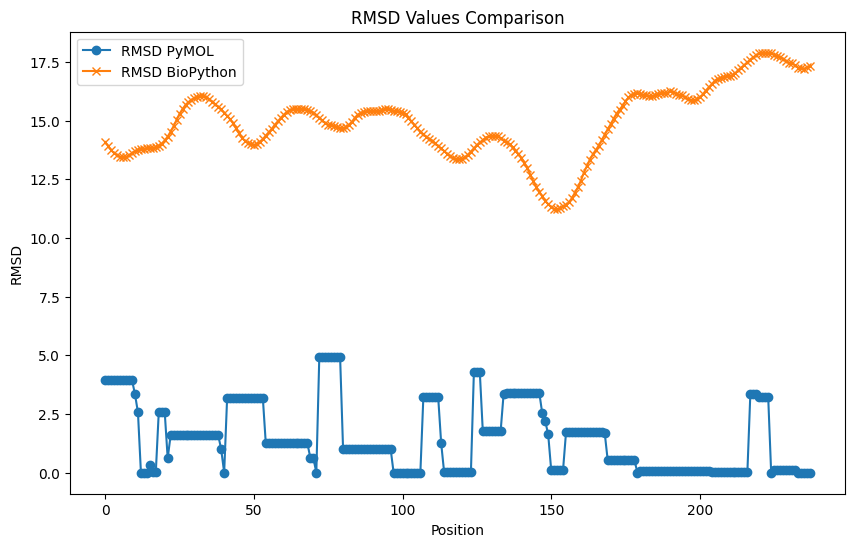

In [40]:

# Generating the positions (x-axis values)
positions = list(range(1, len(rmsd_values_pymol) + 1))
# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(rmsd_values_pymol, label='RMSD PyMOL', marker='o')
#plt.plot(rmsd_values_ampal, label='RMSD AMPAL+PyRMSD', marker='x')
plt.plot(rmsd_values_biopython, label='RMSD BioPython', marker='x')

# Adding labels and title
plt.xlabel('Position')
plt.ylabel('RMSD')
plt.title('RMSD Values Comparison')
plt.legend()

# Show the plot
plt.show()

In [17]:
import multiprocessing
from multiprocessing import Pool
import os

def calculate_sliding_rmsd_wrapper(args):
    reference_pdb, fragment_pdb, step_size = args
    # It's critical to import PyMOL here to ensure each process has its own instance
    import pymol
    from pymol import cmd, stored
    
    # Initialize PyMOL in quiet mode
    pymol.pymol_argv = ['pymol', '-qc']  # Quiet mode, no GUI
    pymol.finish_launching()
    
    cmd.reinitialize()  # Ensure a clean PyMOL session
    cmd.load(reference_pdb, "reference")
    cmd.load(fragment_pdb, "fragment")
    cmd.select("fragment_ca", "fragment and name CA")
    window_size = cmd.count_atoms("fragment_ca")
    n_reference_amino_acids = cmd.count_atoms("reference and name CA")
    rmsd_values = []
    
    for start_resi in range(1, n_reference_amino_acids - window_size + 2, step_size):
        end_resi = start_resi + window_size - 1
        window_selection = f"reference and name CA and resi {start_resi}-{end_resi}"
        cmd.select("current_window", window_selection)
        cmd.create("temp_window", "current_window")
        rmsd = cmd.align("temp_window", "fragment_ca")[0]
        rmsd_values.append(rmsd)
        cmd.delete("temp_window")
    
    cmd.delete("fragment_ca")
    cmd.delete("current_window")
    
    return rmsd_values

def parallel_rmsd_calculation(reference_pdb_path, fragment_paths, step_size=1):
    # Bundle arguments for each task
    tasks = [(reference_pdb_path, frag_path, step_size) for frag_path in fragment_paths]
    
    # Determine the number of processes based on the available CPU cores
    n_processes = min(len(fragment_paths), os.cpu_count())
    
    # Use multiprocessing Pool to parallelize the task execution
    with Pool(processes=n_processes) as pool:
        result = pool.map(calculate_sliding_rmsd_wrapper, tasks)
        
    return result

# Example usage
reference_pdb_path = "../data/pdbs/1A8P.pdb1"
fragment_paths = [fragment_to_path[k] for k in list(fragment_to_path.keys())]  # Replace with your list of fragment paths
step_size = 1
results = parallel_rmsd_calculation(reference_pdb_path, fragment_paths[:3], step_size)

for i, rmsd_values in enumerate(results):
    print(f'Fragment: {fragment_paths[i]}, RMSD values: {rmsd_values}')

KeyboardInterrupt: 

# Just RMSD

In [1]:
import pymol
from pymol import cmd
from Bio.PDB import PDBParser
from Bio.PDB.cealign import CEAligner
import ampal
import tempfile

def calculate_rmsd_cealigner(pdb_file_1, pdb_file_2):
    # Initialize the PDB parser
    parser = PDBParser()

    # Parse the two structures
    structure1 = parser.get_structure('structure1', pdb_file_1)
    structure2 = parser.get_structure('structure2', pdb_file_2)

    # Initialize the CEAligner
    ce_aligner = CEAligner()

    # Perform the alignment
    ce_aligner.set_reference(structure1)
    ce_aligner.align(structure2)

    # Get the RMSD from the alignment
    rmsd = ce_aligner.rms

    return rmsd

def calculate_rmsd_pymol(reference_pdb_path, fragment_pdb_path, normalize=True) -> float:
    pymol.pymol_argv = ["pymol", "-qc"]  # Quiet mode, without GUI
    pymol.finish_launching()
    
    cmd.delete("all")  # Clear any loaded objects
    cmd.load(reference_pdb_path, object="reference")
    cmd.load(fragment_pdb_path, object="fragment")

    # Perform the structural alignment using the align command
    alignment_result = cmd.cealign("reference and name CA", "fragment and name CA")
    rmsd = alignment_result['RMSD']  # Extract RMSD from the result
    return rmsd


In [2]:
calculate_rmsd_cealigner("../data/pdbs/1A8P.pdb1", "../data/pdbs/1A62.pdb1")

6.260138014728223

In [4]:
calculate_rmsd_pymol("../data/pdbs/1A8P.pdb1", "../data/pdbs/1A62.pdb1" )

7.360173298876859

In [6]:
import pymol
from pymol import cmd
from Bio.PDB import PDBParser
from Bio.PDB.cealign import CEAligner
import ampal
import tempfile
import os 
def calculate_rmsd_cealigner(pdb_file_1, pdb_file_2):
    # Initialize the PDB parser
    parser = PDBParser()

    # Parse the two structures
    structure1 = parser.get_structure('structure1', pdb_file_1)
    structure2 = parser.get_structure('structure2', pdb_file_2)

    # Initialize the CEAligner
    ce_aligner = CEAligner(window_size=5)

    # Perform the alignment
    ce_aligner.set_reference(structure1)
    ce_aligner.align(structure2)
    
    # Get the RMSD from the alignment
    rmsd = ce_aligner.rms

    return rmsd

def calculate_rmsd_pymol(reference_pdb_path, fragment_pdb_path, normalize=True) -> float:
    pymol.pymol_argv = ["pymol", "-qc"]  # Quiet mode, without GUI
    pymol.finish_launching()
    
    cmd.delete("all")  # Clear any loaded objects
    cmd.load(reference_pdb_path, object="reference")
    cmd.load(fragment_pdb_path, object="fragment")

    # Perform the structural alignment using the align command
    alignment_result = cmd.cealign("reference and name CA", "fragment and name CA")
    rmsd = alignment_result['RMSD']  # Extract RMSD from the result
    return rmsd

def get_residue_ids(protein_structure):
    """Returns a list of residue IDs from an AMPAL structure."""
    return [residue.id for residue in protein_structure.get_monomers()]


import ampal
import tempfile
import os

def calculate_rmsd_fragment_fixed(reference_pdb_path, fragment_pdb_path, step_size=1):
    # Load the reference and fragment structures using AMPAL
    reference_structure_ampal = ampal.load_pdb(reference_pdb_path)
    fragment_structure_ampal = ampal.load_pdb(fragment_pdb_path)
    if isinstance(reference_structure_ampal, ampal.AmpalContainer):
        reference_structure_ampal = reference_structure_ampal[0][0]  # Assuming single chain for simplicity
    if isinstance(fragment_structure_ampal, ampal.Assembly):
        fragment_structure_ampal = fragment_structure_ampal[0]
    
    rmsd_values = []
    fragment_length = len(fragment_structure_ampal)
    residue_ids = get_residue_ids(reference_structure_ampal)
    print(len(reference_structure_ampal))
    # Adjust loop to ensure 'same' convolution mode-like behavior
    for i in range(0, len(reference_structure_ampal) - fragment_length + 1, step_size):
        segment_ampal = reference_structure_ampal.get_slice_from_res_id(residue_ids[i], residue_ids[i + fragment_length - 1])

        # Use tempfile for better handling of temporary files
        with tempfile.NamedTemporaryFile(delete=False, mode='w+', suffix='.pdb') as segment_file:
            segment_file_path = segment_file.name
            segment_file.write(segment_ampal.make_pdb())

        # Calculate RMSD using the real file and ensure proper use of RMSD calculation function
        rmsd = calculate_rmsd_cealigner(segment_file_path, fragment_pdb_path)  # Assuming this function is correctly implemented elsewhere
        rmsd_values.append(rmsd)
        
        # Ensure the temporary file is deleted
        os.remove(segment_file_path)

    return rmsd_values
import numpy as np
def calculate_rmsd_fragment_averaged(reference_pdb_path, fragment_pdb_path, step_size=1):
    # Load the reference and fragment structures using AMPAL
    reference_structure_ampal = ampal.load_pdb(reference_pdb_path)
    fragment_structure_ampal = ampal.load_pdb(fragment_pdb_path)
    if isinstance(reference_structure_ampal, ampal.AmpalContainer):
        reference_structure_ampal = reference_structure_ampal[0][0]  # Assuming single chain for simplicity
    if isinstance(fragment_structure_ampal, ampal.Assembly):
        fragment_structure_ampal = fragment_structure_ampal[0]
    
    # Initialize arrays to hold the sum of RMSD values and count of additions for each position
    reference_length = len(reference_structure_ampal)
    rmsd_sum = np.zeros(reference_length)
    rmsd_count = np.zeros(reference_length)
    
    fragment_length = len(fragment_structure_ampal)
    residue_ids = get_residue_ids(reference_structure_ampal)

    # Slide the window across the reference structure
    for i in range(0, len(reference_structure_ampal) - fragment_length + 1, step_size):
        segment_ampal = reference_structure_ampal.get_slice_from_res_id(residue_ids[i], residue_ids[i + fragment_length - 1])

        # Use tempfile for better handling of temporary files
        with tempfile.NamedTemporaryFile(delete=False, mode='w+', suffix='.pdb') as segment_file:
            segment_file_path = segment_file.name
            segment_file.write(segment_ampal.make_pdb())

        # Calculate RMSD for the current window
        rmsd = calculate_rmsd_cealigner(segment_file_path, fragment_pdb_path)  # Assuming this function is correctly implemented elsewhere

        # Add RMSD to sum and increment count for positions within the window
        for j in range(i, i + fragment_length):
            rmsd_sum[j] += rmsd
            rmsd_count[j] += 1
        
        # Ensure the temporary file is deleted
        os.remove(segment_file_path)
    
    # Compute the average RMSD for each position
    with np.errstate(divide='ignore', invalid='ignore'):
        rmsd_average = np.divide(rmsd_sum, rmsd_count, out=np.zeros_like(rmsd_sum), where=rmsd_count!=0)

    return rmsd_average.tolist()
reference_pdb_path = "../data/pdbs/1HLV.pdb1"

rmsd = calculate_rmsd_fragment_averaged(reference_pdb_path, "../data/fragments/1/1HLV.pdb1")
len(rmsd)

131

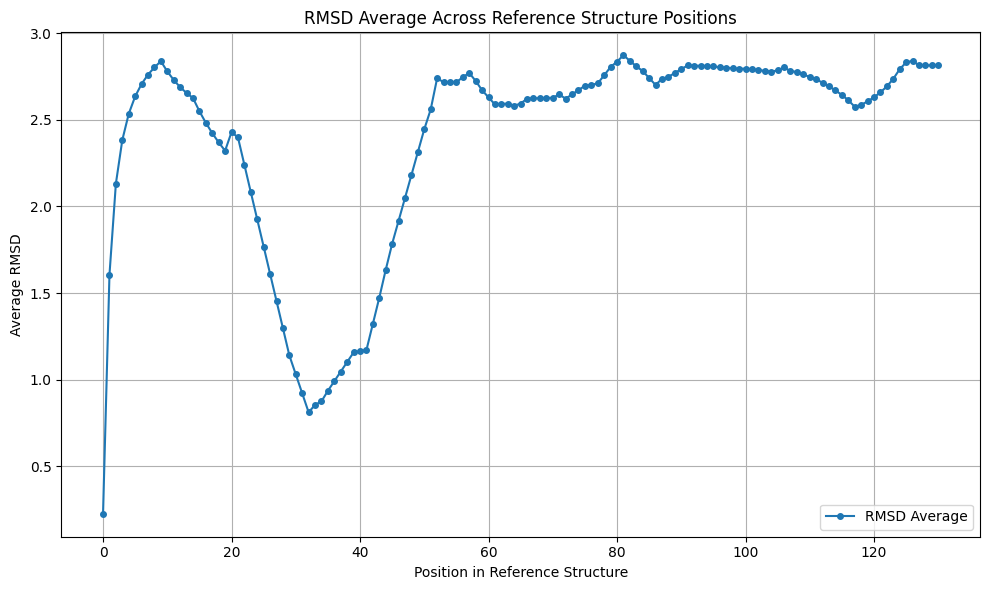

In [8]:
import matplotlib.pyplot as plt
# Code to plot the RMSD average values across the reference structure positions
plt.figure(figsize=(10, 6))
plt.plot(rmsd, marker='o', linestyle='-', markersize=4, label='RMSD Average')
plt.title('RMSD Average Across Reference Structure Positions')
plt.xlabel('Position in Reference Structure')
plt.ylabel('Average RMSD')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [10]:
import sys; print(sys.version)
import platform; print(platform.python_implementation()); print(platform.platform())
import Bio; print(Bio.__version__)

3.8.18 (default, Sep 11 2023, 13:40:15) 
[GCC 11.2.0]
CPython
Linux-5.14.0-1058-oem-x86_64-with-glibc2.17
1.83


In [7]:
rmsd = calculate_rmsd_fragment_averaged(reference_pdb_path, "../data/fragments/2/1CI4.pdb1")

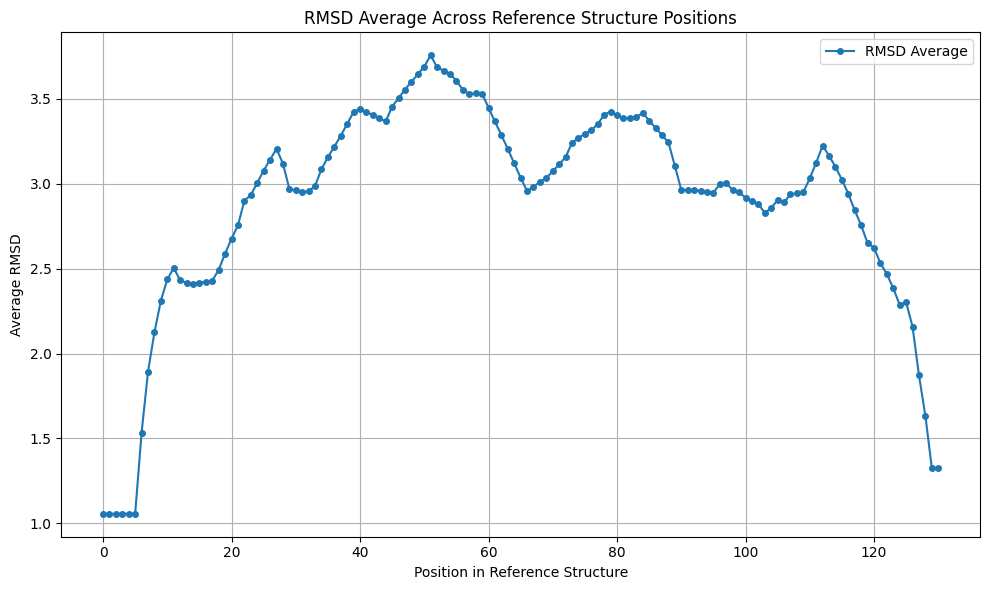

In [8]:
import matplotlib.pyplot as plt
# Code to plot the RMSD average values across the reference structure positions
plt.figure(figsize=(10, 6))
plt.plot(rmsd, marker='o', linestyle='-', markersize=4, label='RMSD Average')
plt.title('RMSD Average Across Reference Structure Positions')
plt.xlabel('Position in Reference Structure')
plt.ylabel('Average RMSD')
plt.grid(True)
plt.legend()
plt.tight_layout()